In [1]:
from barney_functions import add_labels_to_excel,gen_audio_array,buffer,shifter,louder,plot_mel,augment_audio,plot_sample,hsr_loader,lsr_loader,calc_stft,calc_melstft,spec_plot, gen_labels, gen_audio_array_noexcel,augment_audio_faster

In [2]:
import librosa
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import re
import os
from tqdm import tqdm 

# Load Zebra

In [3]:
audio_path = 'zebra audio sample_Bing_413/all/'
audio_path_long = 'Audio Files All/'
spreadsheet_path = 'Zebras.Assumption.data_Bing_413 .xlsx'
df = add_labels_to_excel(spreadsheet_path)
audio_files, index_longest, audio_size = hsr_loader(audio_path,df)
#audio_files_long, audio_size_long, filenames_long, longest_file = gen_audio_array_noexcel(audio_path_long)
zebra_labels = df['label']
#labels_long = gen_labels(filenames_long)

Adding labels


100%|█████████████████████████████████████| 413/413 [00:00<00:00, 206097.27it/s]


Finding longest file (Worse Labels)


100%|████████████████████████████████████████| 413/413 [00:00<00:00, 867.90it/s]


# Generate not zebera

In [4]:
from playsound import playsound
from barney_functions import listen,rand_slices,pad_from_list,gen_nzebra,save_nzebra,add_nzebra
import soundfile as sf

In [5]:
nzebra_path = 'Big_bounce.wav'
nzebra_audio, labels_nzebra = gen_nzebra(nzebra_path,audio_size)
#save_nzebra(nzebra_audio)

Padding


100%|█████████████████████████████████████| 1233/1233 [00:00<00:00, 1532.63it/s]


In [7]:
all_audio, all_lables = add_nzebra(audio_files,zebra_labels,nzebra_audio,labels_nzebra)

# Augment Audio

In [9]:
augmented_audio = augment_audio(audio_files)
#augmented_audio_long = augment_audio(audio_files_long)
#augmented_audio_long_fast = augment_audio_faster(audio_files_long)

Augmenting Non-noise


100%|█████████████████████████████████████████| 413/413 [00:05<00:00, 72.88it/s]


Making noise


100%|█████████████████████████████████████████| 413/413 [00:41<00:00, 10.05it/s]


In [10]:
augmented_audio.shape

(5, 413, 511008)

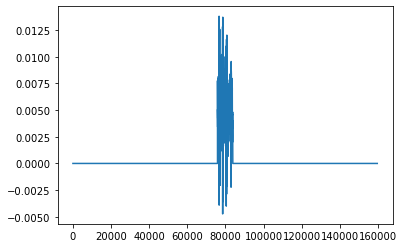

In [11]:
plt.plot(audio_files[400])

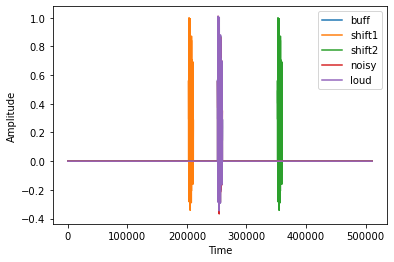

In [12]:
plot_sample(augmented_audio,400)

In [13]:
stfts = calc_stft(augmented_audio)
#stfts_long = calc_stft(augmented_audio_long)
#stfts_long_fast = calc_stft(augmented_audio_long_fast)
#mels = calc_melstft(augmented_audio)

Augmentation  1


100%|█████████████████████████████████████████| 413/413 [00:13<00:00, 30.73it/s]


Augmentation  2


100%|█████████████████████████████████████████| 413/413 [00:14<00:00, 28.52it/s]


Augmentation  3


100%|█████████████████████████████████████████| 413/413 [00:14<00:00, 27.72it/s]


Augmentation  4


100%|█████████████████████████████████████████| 413/413 [00:14<00:00, 28.22it/s]


Augmentation  5


100%|█████████████████████████████████████████| 413/413 [00:14<00:00, 27.63it/s]


In [14]:
stfts.shape

(5, 413, 1025, 999)

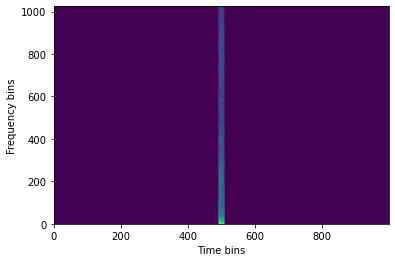

In [15]:
spec_plot(stfts[4,400,:,:])

In [16]:
#np.save('stfts_array',stfts)
#np.save('stfts_array_long',stfts)

In [17]:
#stfts = np.load('stfts_array.npy')
#stfts_long = np.load('stfts_array_long.npy')

In [18]:
stfts_1D = np.zeros(stfts[0].shape)
stfts_1D = stfts[0]
for i in tqdm(range(1,stfts.shape[0])):
    stfts_1D = np.concatenate((stfts_1D,stfts[i]), axis = 0)

100%|█████████████████████████████████████████████| 4/4 [01:23<00:00, 20.97s/it]


In [19]:
stfts_1D.shape

(2065, 1025, 999)